In [2]:
import os 
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


Load Dataset

Data Preprocessing


C:\Users\mo.ghareeb\AppData\Local\Temp\ipykernel_16888\3607464424.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Train: 5216, Test: 624


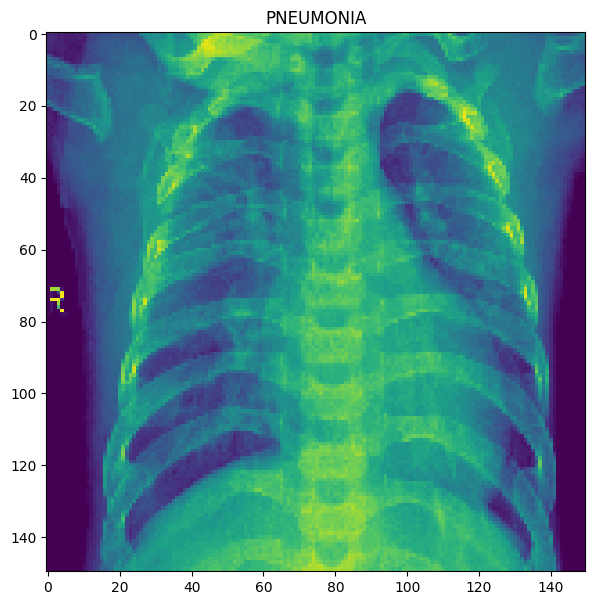

In [3]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('chest_xray/train')
test = get_training_data('chest_xray/test')
val = get_training_data('chest_xray/val')

print(f"Train: {len(train)}, Test: {len(test)}")

plt.figure(figsize=(7, 7))
plt.imshow(train[2][0])
plt.title(labels[train[2][1]])

def cross_validation(dataset):
    X_, y_= [], []
    for x, y in dataset:
        X_.append(x)
        y_.append(y)
    return X_, y_

def normalize(X):
    return np.array(X) / 255

def reshape(X, y, fig_size):
    X = np.array(X).reshape(-1, fig_size[0], fig_size[1], 1)
    y = np.array(y)
    return X, y

def data_argumentation(datagen=None):
    if datagen is None:
        return ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False, 
            zca_whitening=False,  
            rotation_range=30
        )
    return datagen

X_train, y_train = cross_validation(train)
X_test, y_test = cross_validation(test)

X_train = normalize(X_train)
X_test = normalize(X_test)

X_train, y_train = reshape(X_train, y_train, (150, 150))
X_test, y_test = reshape(X_test, y_test, (150, 150))

datagenerator = data_argumentation(None)
datagenerator.fit(X_train)


In [4]:
def get_model(img_size):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=img_size))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model

def get_callback():
    callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath='lstmchar256256128test.h5',
            monitor='val_loss',
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=8,
            mode='auto',
            baseline=None,
        )
    ]
    return callbacks_list

model = get_model((150, 150, 1))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [5]:
epochs = 10

history = model.fit(datagenerator.flow(X_train, y_train, batch_size=32),
                    epochs=epochs, validation_data=(X_test, y_test), callbacks=get_callback())

model.save('PNEUMONIA.h5')


Epoch 1/10
163/163 [==============================] - 199s 1s/step - loss: 0.4223 - accuracy: 0.9132 - val_loss: 9.5689 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 191s 1s/step - loss: 0.1294 - accuracy: 0.9548 - val_loss: 16.6773 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 199s 1s/step - loss: 0.1092 - accuracy: 0.9594 - val_loss: 5.5359 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 188s 1s/step - loss: 0.0988 - accuracy: 0.9634 - val_loss: 1.4902 - val_accuracy: 0.7212
Epoch 5/10
163/163 [==============================] - 187s 1s/step - loss: 0.0926 - accuracy: 0.9680 - val_loss: 0.6719 - val_accuracy: 0.6635
Epoch 6/10
163/163 [==============================] - 186s 1s/step - loss: 0.0831 - accuracy: 0.9701 - val_loss: 0.3314 - val_accuracy: 0.8878
Epoch 7/10
163/163 [==============================] - 186s 1s/step - loss: 0.0813 - accuracy: 0.9703 - val_loss: 2.6723 - val_accuracy: 0.692

In [6]:
def calculate_iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return iou.numpy()

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    iou = calculate_iou(y_test, y_pred_classes)
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"IoU: {iou}")

evaluate_model(model, X_test, y_test)


20/20 [==============================] - 4s 206ms/step
Precision: 0.8006908249133738
Recall: 0.719551282051282
F1 Score: 0.66277322282889
IoU: 0.25531914830207825


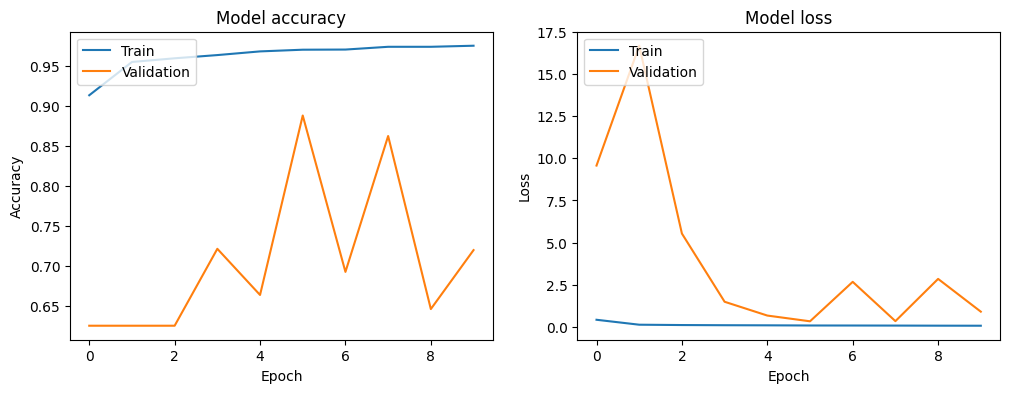

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


1/1 [==============================] - 0s 29ms/step


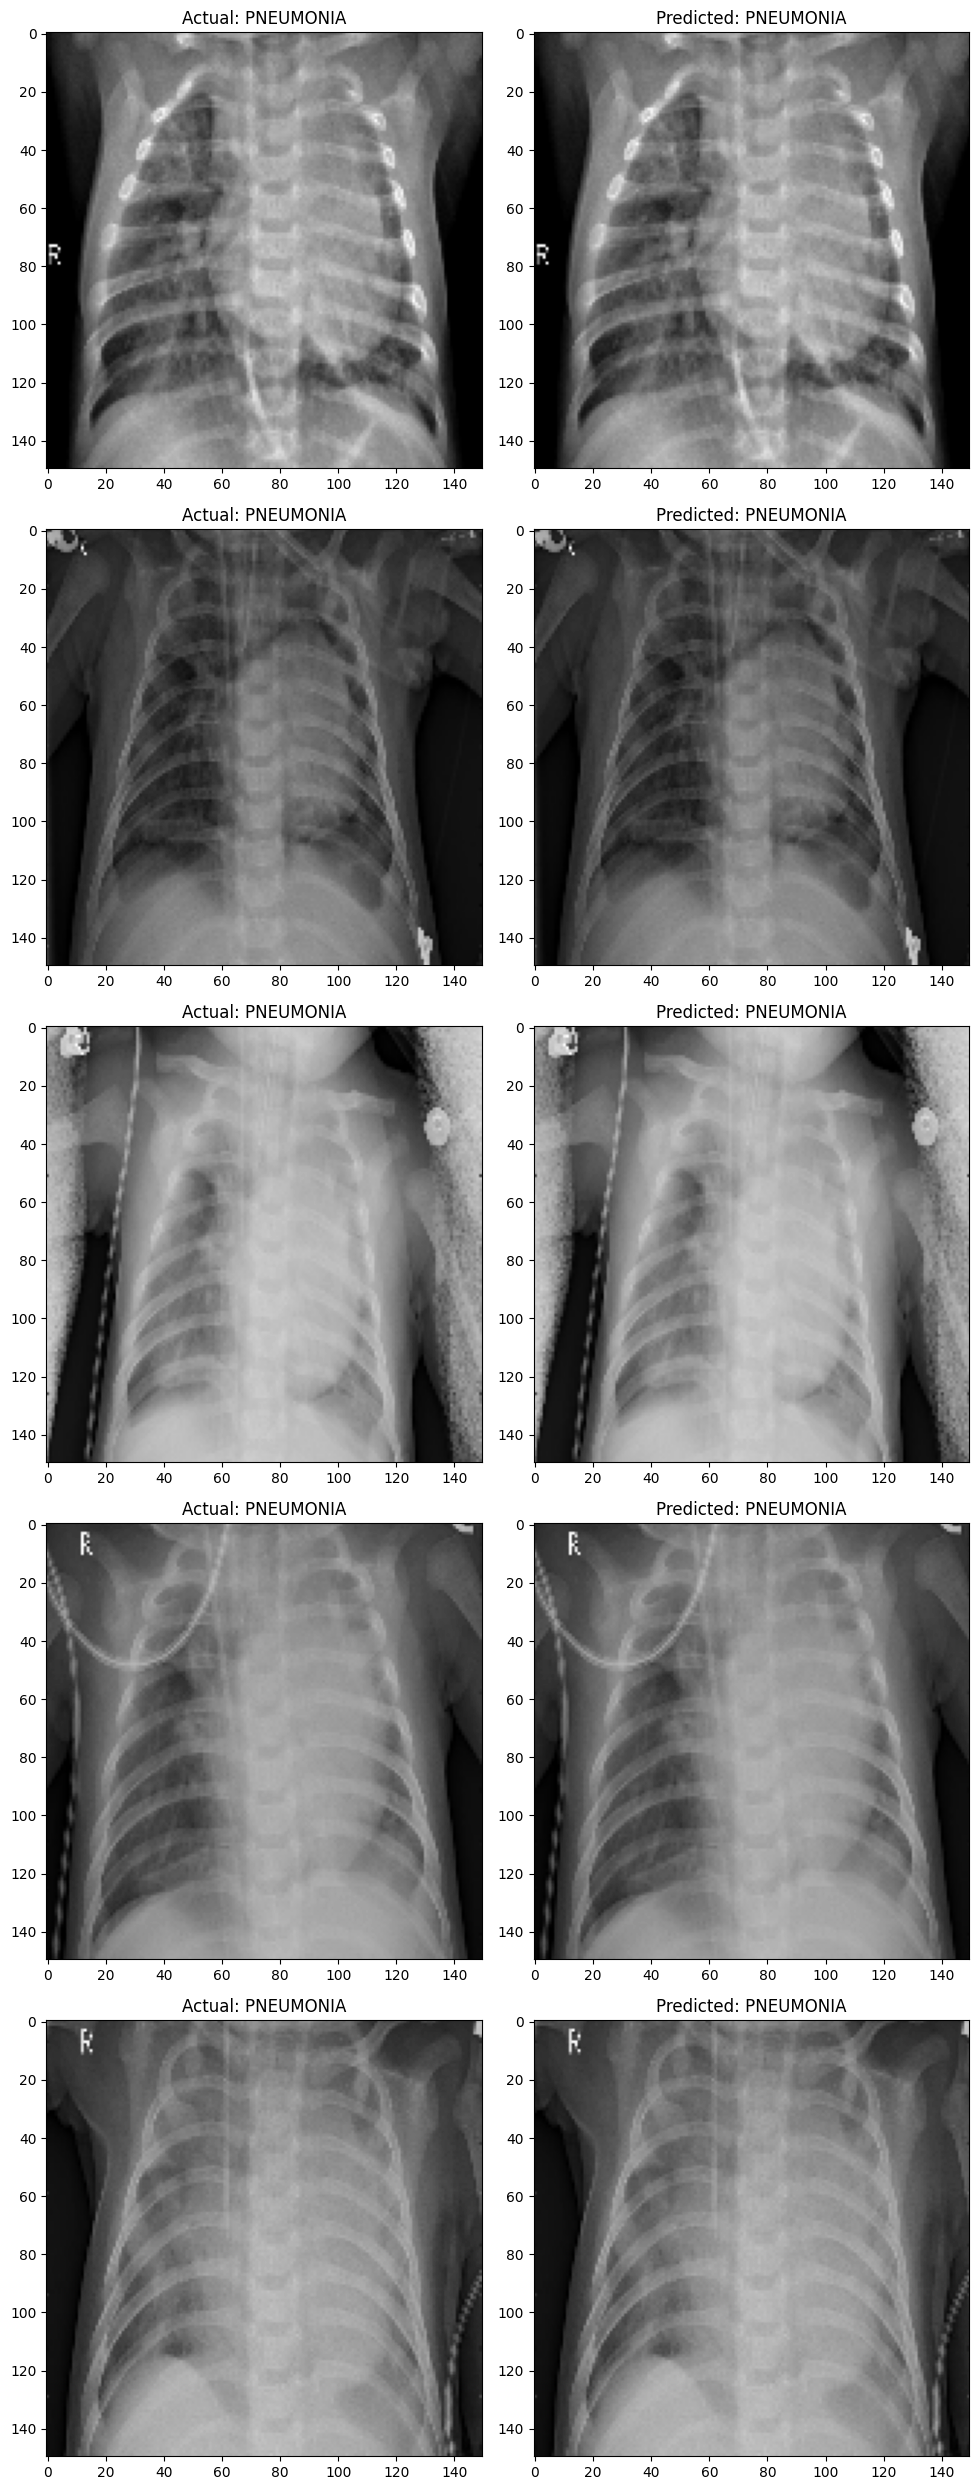

In [8]:
def visualize_segmentation(model, X_test, y_test, labels, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        ax = axes[i, 0]
        ax.imshow(X_test[i].reshape(150, 150), cmap='gray')
        ax.set_title(f"Actual: {labels[y_test[i]]}")
        
        ax = axes[i, 1]
        prediction = model.predict(np.expand_dims(X_test[i], axis=0))
        predicted_class = np.argmax(prediction)
        ax.imshow(X_test[i].reshape(150, 150), cmap='gray')
        ax.set_title(f"Predicted: {labels[predicted_class]}")
    
    plt.tight_layout()
    plt.show()

visualize_segmentation(model, X_test, y_test, labels)
